# Training Deep Neural Networks on a GPU with Tensorflow

This notebook is a tensorflow port of https://jovian.ml/aakashns/04-feedforward-nn

Despite the structural differences in Tensorflow and PyTorch, I have tried to port the torch notebooks to tensorflow, which helps in learning both frameworks along with the course [PyTorch: Zero to GANs](https://jovian.ml/aakashns/01-pytorch-basics) by Aakash


### Part 4 of "Tensorflow: Zero to GANs"

*This notebook is the fourth in a series of tutorials on building deep learning models with Tensorflow, an open source neural networks library. Check out the full series:*

1. [Tensorflow Basics: Tensors & Gradients](https://jovian.ml/kartik.godawat/01-tensorflow-basics)
2. [Linear Regression & Gradient Descent](https://jovian.ml/kartik.godawat/02-tf-linear-regression)
3. [Image Classfication using Logistic Regression](https://jovian.ml/kartik.godawat/03-tf-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ml/kartik.godawat/04-tf-feedforward-nn)


In [the previous tutorial](https://jovian.ml/kartik.godawat/03-tf-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. 

![](https://cdn-images-1.medium.com/max/1600/1*q2nyeRU8uvjPeKpo_lMXgQ.jpeg)

However, we also noticed that it's quite difficult to improve the accuracy beyond 87%, due to the limited power of the model. In this post, we'll try to improve upon it using a *feedforward neural network*. 

## Preparing the Data

The data preparation is identical to the [previous tutorial](https://jovian.ml/kartik.godawat/03-tf-logistic-regression/v/2#C22). We begin by importing the required modules & classes.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
import tensorflow_datasets as tfds

To view the device on which operations are performed, uncomment this line and run

In [2]:
# tf.debugging.set_log_device_placement(True)

In [3]:
(ds, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [4]:
ds = ds.shuffle(buffer_size=100)
train_ds = ds.take(50000)
val_ds = ds.skip(50000)

In [5]:
len(list(train_ds)), len(list(val_ds))

(50000, 10000)

In [6]:
batch_size = 128
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

## Model

To improve upon [logistic regression](https://jovian.ml/kartik.godawat/03-tf-logistic-regression), we'll create a neural network with one **hidden layer**. Here's what this means:

* Instead of using a single `Dense` layer to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `Dense` layers. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

We define the model using `Sequential` from keras, just as we did with logistic regression.

We'll create a model that contains a hidden layer with 32 activations.

In [7]:
hidden_size = 32
num_classes = 10

model = Sequential([
    Dense(hidden_size, input_shape=(28*28,), activation="relu"),
    Dense(num_classes)
])

Layers shape can be accessed by viewing `layer.output_shape` and the activation can be verified by looking at `layer.activation`

In [8]:
for layer in model.layers:
    print(layer.output_shape, layer.activation)

(None, 32) <function relu at 0x7f4111cde268>
(None, 10) <function linear at 0x7f4111cde510>


Just like we did [before](https://jovian.ml/kartik.godawat/03-tf-logistic-regression/v/2#C60), we reshape the input and batch the dataset, while also normalizing the dataset.

In [9]:
def mapp(x):
    x = x / 255
    return tf.reshape(x, [28*28])
train_ds = train_ds.unbatch().map(lambda x,y: (mapp(x),y)).batch(batch_size)
val_ds = val_ds.unbatch().map(lambda x,y: (mapp(x),y)).batch(batch_size)

Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset, and pass them into our model.

In [10]:
for images, labels in train_ds:
    outputs = model(images)
    break
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2])

outputs.shape :  (128, 10)
Sample outputs :
 tf.Tensor(
[[-0.3719551  -0.27709225 -0.37832576  0.30584988 -0.25548273  0.0816628
  -0.00279802 -0.01136872 -0.1388574  -0.04742745]
 [ 0.01267302  0.28078642  0.3635273   0.09322667 -0.04257113  0.5249153
   0.03592832  0.55380964 -1.0067574  -0.656198  ]], shape=(2, 10), dtype=float32)


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on [Kaggle kernels](https://www.kaggle.com/kernels) or [Google Colab](https://colab.research.google.com/), or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html) or [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `tf.config.list_physical_devices('GPU')`.

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Note that if a GPU is available, tensorflow automatically will default the model operations on the GPU

## Training the Model
We can use the exact same training loops from the [logistic regression notebook](https://jovian.ml/kartik.godawat/03-tf-logistic-regression).

In [12]:
def accuracy(outputs, labels):
    preds = tf.argmax(outputs, axis=1)
    return tf.reduce_sum(tf.cast(preds == labels, dtype=tf.int32)) / len(preds)

loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [13]:
def validation_step(model, x, y):
    out = model(x)
    out = tf.nn.softmax(out)
    loss = loss_fn(out, tf.keras.utils.to_categorical(y, num_classes=num_classes))
    acc = accuracy(out, y)
    return {'loss': loss, 'acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['loss'] for x in outputs]
    epoch_loss = tf.reduce_mean(batch_losses)   # Combine losses
    batch_accs = [x['acc'] for x in outputs]
    epoch_acc =  tf.reduce_mean(batch_accs)      # Combine accuracies
    return {'loss': epoch_loss, 'acc': epoch_acc}

In [14]:
def evaluate(model, val_ds):
    outputs = []
    for x, y in val_ds:
        outputs.append(validation_step(model, x, y))
    return validation_epoch_end(outputs)

def fit(epochs, lr, model, train_ds, val_ds, opt_func=tf.keras.optimizers.SGD):
    history = []
    optimizer = opt_func(lr)
    for epoch in range(epochs):
        # Training Phase 
        for x, y in train_ds:
            # Record all operations under GradientTape, so that gradients can be tracked and calculated later
            with tf.GradientTape() as tape:
                out = model(x)
                out = tf.nn.softmax(out)
                loss = loss_fn(out, tf.keras.utils.to_categorical(y, num_classes=10))
            var_list_fn =  model.trainable_weights
            # Compute gradients
            grads = tape.gradient(loss, var_list_fn)
#             print(grads)
            # Apply gradients
            optimizer.apply_gradients(zip(grads, var_list_fn))
        # Validation phase
        result = evaluate(model, train_ds)
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}".format(epoch, result['loss'], result['acc']))
        result = evaluate(model, val_ds)
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['loss'], result['acc']))
        history.append(result)
    return history

In [15]:
result0 = evaluate(model, val_ds)
result0

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=14.476842>,
 'acc': <tf.Tensor: shape=(), dtype=float64, numpy=0.12450553797468354>}

### GPU vs CPU execution
In tensorflow, GPU or CPU execution can be controlled by using `tf.device()` blocks. We can either use the fullhand notation or the shorthand notation `/GPU:0` or `/CPU:0` indicating the first GPU or the CPU in the machine. 

Note that just like GPU, `/CPU:0` refers to entire physical CPU device and not one core of the CPU.

Since tf uses GPU by default if available, we don't need to set this block explicitly everytime, but if needed, we can still go ahead and use it

In [16]:
with tf.device('/GPU:0'):
    history = fit(5, 0.001, model, train_ds, val_ds)

Epoch [0], train_loss: 12.7477, train_acc: 0.3773
Epoch [0], val_loss: 12.7319, val_acc: 0.3830
Epoch [1], train_loss: 9.2203, train_acc: 0.4996
Epoch [1], val_loss: 9.1994, val_acc: 0.5045
Epoch [2], train_loss: 7.5427, train_acc: 0.6166
Epoch [2], val_loss: 7.5261, val_acc: 0.6198
Epoch [3], train_loss: 6.6824, train_acc: 0.6567
Epoch [3], val_loss: 6.6122, val_acc: 0.6623
Epoch [4], train_loss: 5.8708, train_acc: 0.7043
Epoch [4], val_loss: 5.8282, val_acc: 0.7085


Now let's try training for a couple more epochs, this time on a CPU

In [17]:
with tf.device('/CPU:0'):
    history += fit(15, 0.001, model, train_ds, val_ds)

Epoch [0], train_loss: 5.4913, train_acc: 0.7145
Epoch [0], val_loss: 5.4839, val_acc: 0.7144
Epoch [1], train_loss: 5.2492, train_acc: 0.7219
Epoch [1], val_loss: 5.2195, val_acc: 0.7222
Epoch [2], train_loss: 5.0862, train_acc: 0.7258
Epoch [2], val_loss: 5.0862, val_acc: 0.7260
Epoch [3], train_loss: 4.9617, train_acc: 0.7290
Epoch [3], val_loss: 4.9126, val_acc: 0.7327
Epoch [4], train_loss: 4.8642, train_acc: 0.7319
Epoch [4], val_loss: 4.8052, val_acc: 0.7345
Epoch [5], train_loss: 4.7890, train_acc: 0.7336
Epoch [5], val_loss: 4.7623, val_acc: 0.7341
Epoch [6], train_loss: 4.7238, train_acc: 0.7354
Epoch [6], val_loss: 4.6766, val_acc: 0.7367
Epoch [7], train_loss: 4.6720, train_acc: 0.7367
Epoch [7], val_loss: 4.6415, val_acc: 0.7373
Epoch [8], train_loss: 4.6234, train_acc: 0.7382
Epoch [8], val_loss: 4.6268, val_acc: 0.7371
Epoch [9], train_loss: 4.5820, train_acc: 0.7394
Epoch [9], val_loss: 4.5617, val_acc: 0.7404
Epoch [10], train_loss: 4.5479, train_acc: 0.7403
Epoch [10]

If you're unsure if behind the scenes it actually used a CPU this time, restarting the notebook by uncommenting `tf.debugging.set_log_device_placement(True)` and executing can be used to debug the placement of the operations and the model itself.

Did you note that GPU speed seems comparable to that of CPU? That is because our model has only two dense layer and very limited number of operations to perform. However, as the model and the computations become increasingly complex, GPU benchmarks start to outshine CPU speed.

We can now plot the losses & accuracies to study how the model improves over time.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

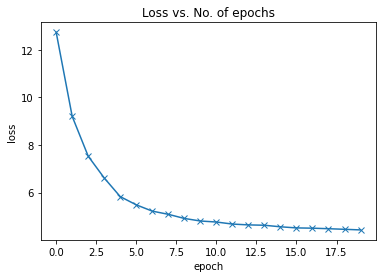

In [19]:
losses = [x['loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

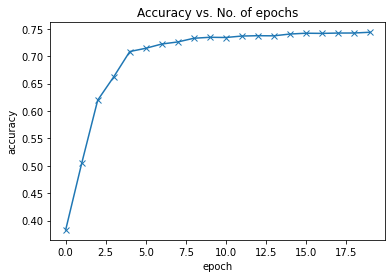

In [20]:
accuracies = [x['acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Commit and upload the notebook

As a final step, we can save and commit our work using the jovian library.

In [21]:
!pip install jovian --upgrade -q

You should consider upgrading via the '/home/d/envs/tftwo/bin/python3.6 -m pip install --upgrade pip' command.


In [ ]:
import jovian
jovian.commit(filename='04-tf-feedforward-nn', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
